Nama : Yogianna Nur Febrianti

Kelas : TI 2F

- Buatlah model klasifikasi dengan menggunakan SVM berdasarkan data pada Percobaan 5 dengan menggunakan fitur histogram.

In [14]:
# Menghubungkan Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 Mengimpor Library yang Diperlukan

- matplotlib untuk menampilkan plot histogram.

- cv2 (OpenCV) untuk memproses gambar.

- numpy untuk manipulasi data array.

- sklearn.metrics untuk mengevaluasi model.

- os untuk membaca file gambar dari direktori.

In [15]:
# Import Required Libraries
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.metrics import accuracy_score
import os

In [16]:
# Menyiapkan Direktori Data

train_dir = "/content/drive/MyDrive/asset/images/test"
test_dir = "/content/drive/MyDrive/asset/images/training"

- Membaca Gambar dan Menghitung Histogram

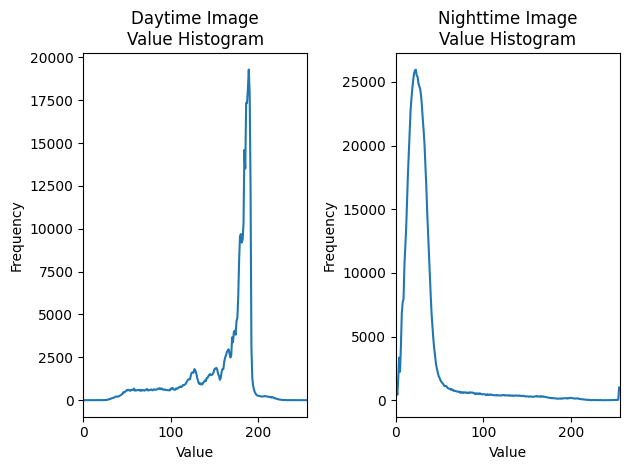

In [18]:
day_img = cv2.imread('/content/drive/MyDrive/asset/images/test/day/20151102_005050.jpg')
night_img = cv2.imread('/content/drive/MyDrive/asset/images/test/night/20151101_072507.jpg')

# Convert to HSV
day_hsv = cv2.cvtColor(day_img, cv2.COLOR_BGR2HSV)
night_hsv = cv2.cvtColor(night_img, cv2.COLOR_BGR2HSV)

# Extract Value channels
day_v = day_hsv[:, :, 2]
night_v = night_hsv[:, :, 2]

# Calculate histograms
day_hist = cv2.calcHist([day_v], [0], None, [256], [0, 256])
night_hist = cv2.calcHist([night_v], [0], None, [256], [0, 256])

# Plot histograms in subplots
plt.figure()

# Daytime Image
plt.subplot(1, 2, 1)
plt.title("Daytime Image\nValue Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.plot(day_hist)
plt.xlim([0, 256])

# Nighttime Image
plt.subplot(1, 2, 2)
plt.title("Nighttime Image\nValue Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.plot(night_hist)
plt.xlim([0, 256])

plt.tight_layout() # Adjust layout for better spacing
plt.show()

- Menghitung histogram dari gambar berdasarkan 3 kanal (Hue, Saturation, Value) dengan 16 bin untuk setiap kanal. Histogram kemudian dinormalisasi dan diratakan untuk digunakan sebagai fitur.

In [19]:
def compute_histogram(image):
    # Convert the image to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Compute the histogram (16 bins for each channel)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [16, 16, 16], [0, 180, 0, 256, 0, 256])

    # Normalize the histogram
    cv2.normalize(hist, hist)

    # Flatten the histogram to create the feature vector
    return hist.flatten()

In [20]:
# Fungsi untuk Standarisasi Ukuran Gambar

def standarized_input(image):
    # resize to w: 1100, h:600
    std_img = cv2.resize(image, (1100,600))

    return std_img

- Memuat gambar dari direktori berdasarkan label day (siang) dan night (malam), menghitung histogram setiap gambar, dan mengembalikan array fitur dan label.

In [21]:
def load_data(directory):
    data = []
    labels = []

    for label in ['day', 'night']:
        path = os.path.join(directory, label)
        for filename in os.listdir(path):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                img_path = os.path.join(path, filename)

                # Read and resize the image
                image = cv2.imread(img_path)
                resized_image = standarized_input(image)

                # Compute histogram features
                hist = compute_histogram(resized_image)

                # Append features and label
                data.append(hist)
                labels.append(0 if label == 'night' else 1)  # 0 for night, 1 for day

    return np.array(data), np.array(labels)

In [22]:
# Mengimpor library
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Create a pipeline that combines PCA and the classifier
pipe = Pipeline(steps=[
    ('pca', PCA()),
    ('svm', SVC)
])

In [30]:
# Memanggil fungsi load_data yang sebelumnya telah didefinisikan untuk memuat data gambar dari direktori train_dir dan test_dir.

train_data, train_labels = load_data(train_dir)
test_data, test_labels = load_data(test_dir)

In [31]:
print(train_data[0])
print(train_labels[0])

type(train_labels)

[0.         0.00752492 0.0101713  ... 0.         0.         0.        ]
1


numpy.ndarray

- Membangun Model SVM dengan PCA dan GridSearch

In [29]:
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

# Create a pipeline with PCA and SVM
pipe = Pipeline(steps=[
    ('pca', PCA()),
    ('svm', svm.SVC())
])

# Define the parameter grid for GridSearch
param_grid = {
    'pca__n_components': [10, 20, 30, 50, 100, 128],  # Disesuaikan dengan data
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')

# Fit the model on training data
grid_search.fit(train_data, train_labels)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'pca__n_components': 20, 'svm__C': 10, 'svm__kernel': 'rbf'}
0.89375


- Evaluasi Model

In [27]:
# Get the best model from GridSearch
best_model = grid_search.best_estimator_

# Predict on train data
train_predictions = best_model.predict(train_data)
# Predict on test data
test_predictions = best_model.predict(test_data)

# Evaluate accuracy
train_accuracy = accuracy_score(train_labels, train_predictions)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")

test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Train Accuracy: 100.00%
Test Accuracy: 99.17%
